In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
zip_path = '/content/Persian Car Plate Dataset.zip'
extract_path = '/content/PCPD'
dataset_path = '/content/PCPD/Persian Car Plate Dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
print(os.listdir('/content/PCPD/Persian Car Plate Dataset'))
print(os.listdir('/content/PCPD/Persian Car Plate Dataset/images'))

['images', 'MetaData.csv']
['170.jpeg', '131.jpeg', '194.jpeg', '995.jpeg', '1117.jpeg', '4408.jpeg', '1012.jpeg', '2152.jpeg', '1681.jpeg', '498.jpeg', '569.jpeg', '1106.jpeg', '4220.jpeg', '689.jpeg', '65.jpeg', '88.jpeg', '59.jpeg', '1119.jpeg', '52.jpeg', '3429.jpeg', '1037.jpeg', '2677.jpeg', '1188.jpeg', '182.jpeg', '3144.jpeg', '3756.jpeg', '398.jpeg', '5.jpeg', '1785.jpeg', '4691.jpeg', '237.jpeg', '3363.jpeg', '658.jpeg', '517.jpeg', '160.jpeg', '4146.jpeg', '5034.jpeg', '2030.jpeg', '102.jpeg', '202.jpeg', '239.jpeg', '1033.jpeg', '4113.jpeg', '979.jpeg', '457.jpeg', '499.jpeg', '4709.jpeg', '2425.jpeg', '4565.jpeg', '3041.jpeg', '27.jpeg', '87.jpeg', '4459.jpeg', '2070.jpeg', '1017.jpeg', '986.jpeg', '122.jpeg', '1152.jpeg', '147.jpeg', '3549.jpeg', '1323.jpeg', '218.jpeg', '94.jpeg', '3970.jpeg', '2493.jpeg', '6.jpeg', '2308.jpeg', '2992.jpeg', '947.jpeg', '4524.jpeg', '2983.jpeg', '2224.jpeg', '2310.jpeg', '356.jpeg', '1746.jpeg', '497.jpeg', '4963.jpeg', '217.jpeg', '629.

In [ ]:
metadata = pd.read_csv(os.path.join(extract_path, 'Persian Car Plate Dataset', 'MetaData.csv'))
metadata['image_path'] = metadata['ID'].apply(lambda x: os.path.join(extract_path, 'Persian Car Plate Dataset', 'images', f'{x}.jpeg'))

In [ ]:
print("Contents of extracted folder:")
print(os.listdir(extract_path))
print("\nContents of dataset folder:")
print(os.listdir(dataset_path))
print("\nContents of images folder:")
print(os.listdir(os.path.join(dataset_path, 'images')))

Contents of extracted folder:
['Persian Car Plate Dataset']

Contents of dataset folder:
['images', 'MetaData.csv']

Contents of images folder:
['170.jpeg', '131.jpeg', '194.jpeg', '995.jpeg', '1117.jpeg', '4408.jpeg', '1012.jpeg', '2152.jpeg', '1681.jpeg', '498.jpeg', '569.jpeg', '1106.jpeg', '4220.jpeg', '689.jpeg', '65.jpeg', '88.jpeg', '59.jpeg', '1119.jpeg', '52.jpeg', '3429.jpeg', '1037.jpeg', '2677.jpeg', '1188.jpeg', '182.jpeg', '3144.jpeg', '3756.jpeg', '398.jpeg', '5.jpeg', '1785.jpeg', '4691.jpeg', '237.jpeg', '3363.jpeg', '658.jpeg', '517.jpeg', '160.jpeg', '4146.jpeg', '5034.jpeg', '2030.jpeg', '102.jpeg', '202.jpeg', '239.jpeg', '1033.jpeg', '4113.jpeg', '979.jpeg', '457.jpeg', '499.jpeg', '4709.jpeg', '2425.jpeg', '4565.jpeg', '3041.jpeg', '27.jpeg', '87.jpeg', '4459.jpeg', '2070.jpeg', '1017.jpeg', '986.jpeg', '122.jpeg', '1152.jpeg', '147.jpeg', '3549.jpeg', '1323.jpeg', '218.jpeg', '94.jpeg', '3970.jpeg', '2493.jpeg', '6.jpeg', '2308.jpeg', '2992.jpeg', '947.jpeg', '4

In [ ]:
print("\nSample image paths:")
print(metadata['image_path'].head())


Sample image paths:
0    /content/PCPD/Persian Car Plate Dataset/images...
1    /content/PCPD/Persian Car Plate Dataset/images...
2    /content/PCPD/Persian Car Plate Dataset/images...
3    /content/PCPD/Persian Car Plate Dataset/images...
4    /content/PCPD/Persian Car Plate Dataset/images...
Name: image_path, dtype: object


In [ ]:
def check_image_files(metadata):
    missing_files = []
    for _, row in metadata.iterrows():
        if not os.path.exists(row['image_path']):
            missing_files.append(row['image_path'])

    if missing_files:
        print(f"Warning: {len(missing_files)} image files are missing.")
        print("First few missing files:")
        print(missing_files[:5])
    else:
        print("All image files exist.")

check_image_files(metadata)

First few missing files:
['/content/PCPD/Persian Car Plate Dataset/images/1888.jpeg', '/content/PCPD/Persian Car Plate Dataset/images/1889.jpeg', '/content/PCPD/Persian Car Plate Dataset/images/1890.jpeg', '/content/PCPD/Persian Car Plate Dataset/images/1888.jpeg', '/content/PCPD/Persian Car Plate Dataset/images/1889.jpeg']


In [ ]:
print(f"befor filter : {len(metadata)}")
metadata = metadata[metadata['image_path'].apply(os.path.exists)]
print(f"after filter : {len(metadata)}")

befor filter : 1194
after filter : 1188


In [ ]:
label_encoders = {}
categorical_columns = ['CarModel','Color','Status']

for column in categorical_columns:
    le = LabelEncoder()
    metadata[f'{column}_encoded'] = le.fit_transform(metadata[column])
    label_encoders[column] = le

In [ ]:
train_data, val_data = train_test_split(metadata, test_size=0.2, random_state=42)

In [ ]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=50.0
)

val_datagen = ImageDataGenerator(rescale=1./255)

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return img_array

def data_generator(data, batch_size, is_training=True):
    while True:
        for i in range(0, len(data), batch_size):
            batch_data = data.iloc[i:i+batch_size]
            batch_images = []
            batch_labels = {col: [] for col in categorical_columns}

            for _, row in batch_data.iterrows():
                img = preprocess_image(row['image_path'])
                batch_images.append(img)

                for col in categorical_columns:
                    batch_labels[col].append(label_encoders[col].transform([row[col]])[0])

            batch_images = np.array(batch_images)
            for col in categorical_columns:
                batch_labels[col] = np.array(batch_labels[col])

            yield batch_images, batch_labels

In [14]:
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(1,),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        at = tf.keras.backend.softmax(et, axis=1)
        output = x * at
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = AttentionLayer()(x)

outputs = {}
for column in categorical_columns:
    num_classes = len(label_encoders[column].classes_)
    outputs[column] = layers.Dense(num_classes, activation='softmax', name=column)(x)

model = models.Model(inputs=inputs, outputs=outputs)

loss_weights = {
    'CarModel': 1.5,
    'Color': 1.0,
    'Status': 1.0,
}

model.compile(optimizer='adam',
              loss={col: 'sparse_categorical_crossentropy' for col in categorical_columns},
              loss_weights=loss_weights,
              metrics={col: 'accuracy' for col in categorical_columns})

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    data_generator(train_data, batch_size),
    steps_per_epoch=len(train_data) // batch_size,
    epochs=100,
    validation_data=data_generator(val_data, batch_size, is_training=False),
    validation_steps=len(val_data) // batch_size,
    callbacks=[reduce_lr]
)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 109s 699ms/step - CarModel_accuracy: 0.1528 - Color_accuracy: 0.2957 - Status_accuracy: 0.7265 - loss: 8.2705 - val_CarModel_accuracy: 0.0893 - val_Color_accuracy: 0.2098 - val_Status_accuracy: 0.4554 - val_loss: 8.7164 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 83s 587ms/step - CarModel_accuracy: 0.4853 - Color_accuracy: 0.5789 - Status_accuracy: 0.9323 - loss: 4.8888 - val_CarModel_accuracy: 0.0146 - val_Color_accuracy: 0.2282 - val_Status_accuracy: 0.4757 - val_loss: 9.3070 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - CarModel_accuracy: 0.6967 - Color_accuracy: 0.7020 - Status_accuracy: 0.9642 - loss: 3.0634 - val_CarModel_accuracy: 0.0146 - val_Color_accuracy: 0.2136 - val_Status_accuracy: 0.5340 - val_loss: 10.3085 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - CarModel_accuracy: 0.8042 - Color_accuracy: 0.8146 - Status_accuracy: 0.9618 - loss: 1.8951 - va

dict_keys(['CarModel_accuracy', 'Color_accuracy', 'Status_accuracy', 'loss', 'val_CarModel_accuracy', 'val_Color_accuracy', 'val_Status_accuracy', 'val_loss', 'learning_rate'])


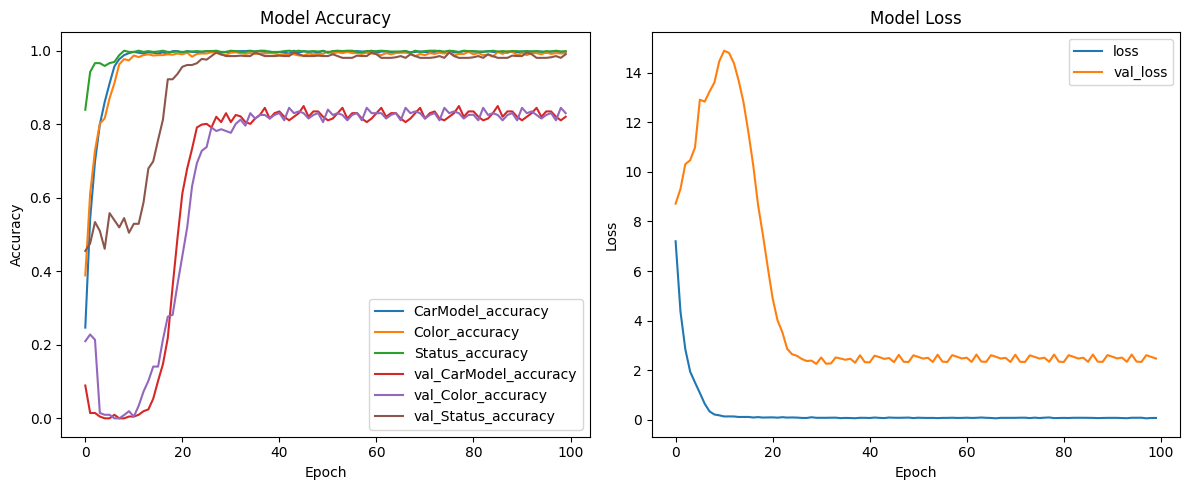

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    print(history.history.keys())

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    for key in history.history.keys():
        if 'acc' in key and 'val' not in key:
            plt.plot(history.history[key], label=key)
    for key in history.history.keys():
        if 'acc' in key and 'val' in key:
            plt.plot(history.history[key], label=key)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(122)
    for key in history.history.keys():
        if 'loss' in key and 'val' not in key:
            plt.plot(history.history[key], label=key)
    for key in history.history.keys():
        if 'loss' in key and 'val' in key:
            plt.plot(history.history[key], label=key)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [16]:
model.save('/content/car_plate_model.keras')

In [17]:
def predict_car_info(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)

    results = {}
    for column, pred in zip(categorical_columns, predictions.values()):
        predicted_class = label_encoders[column].inverse_transform([np.argmax(pred[0])])[0]
        results[column] = predicted_class

    return results

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


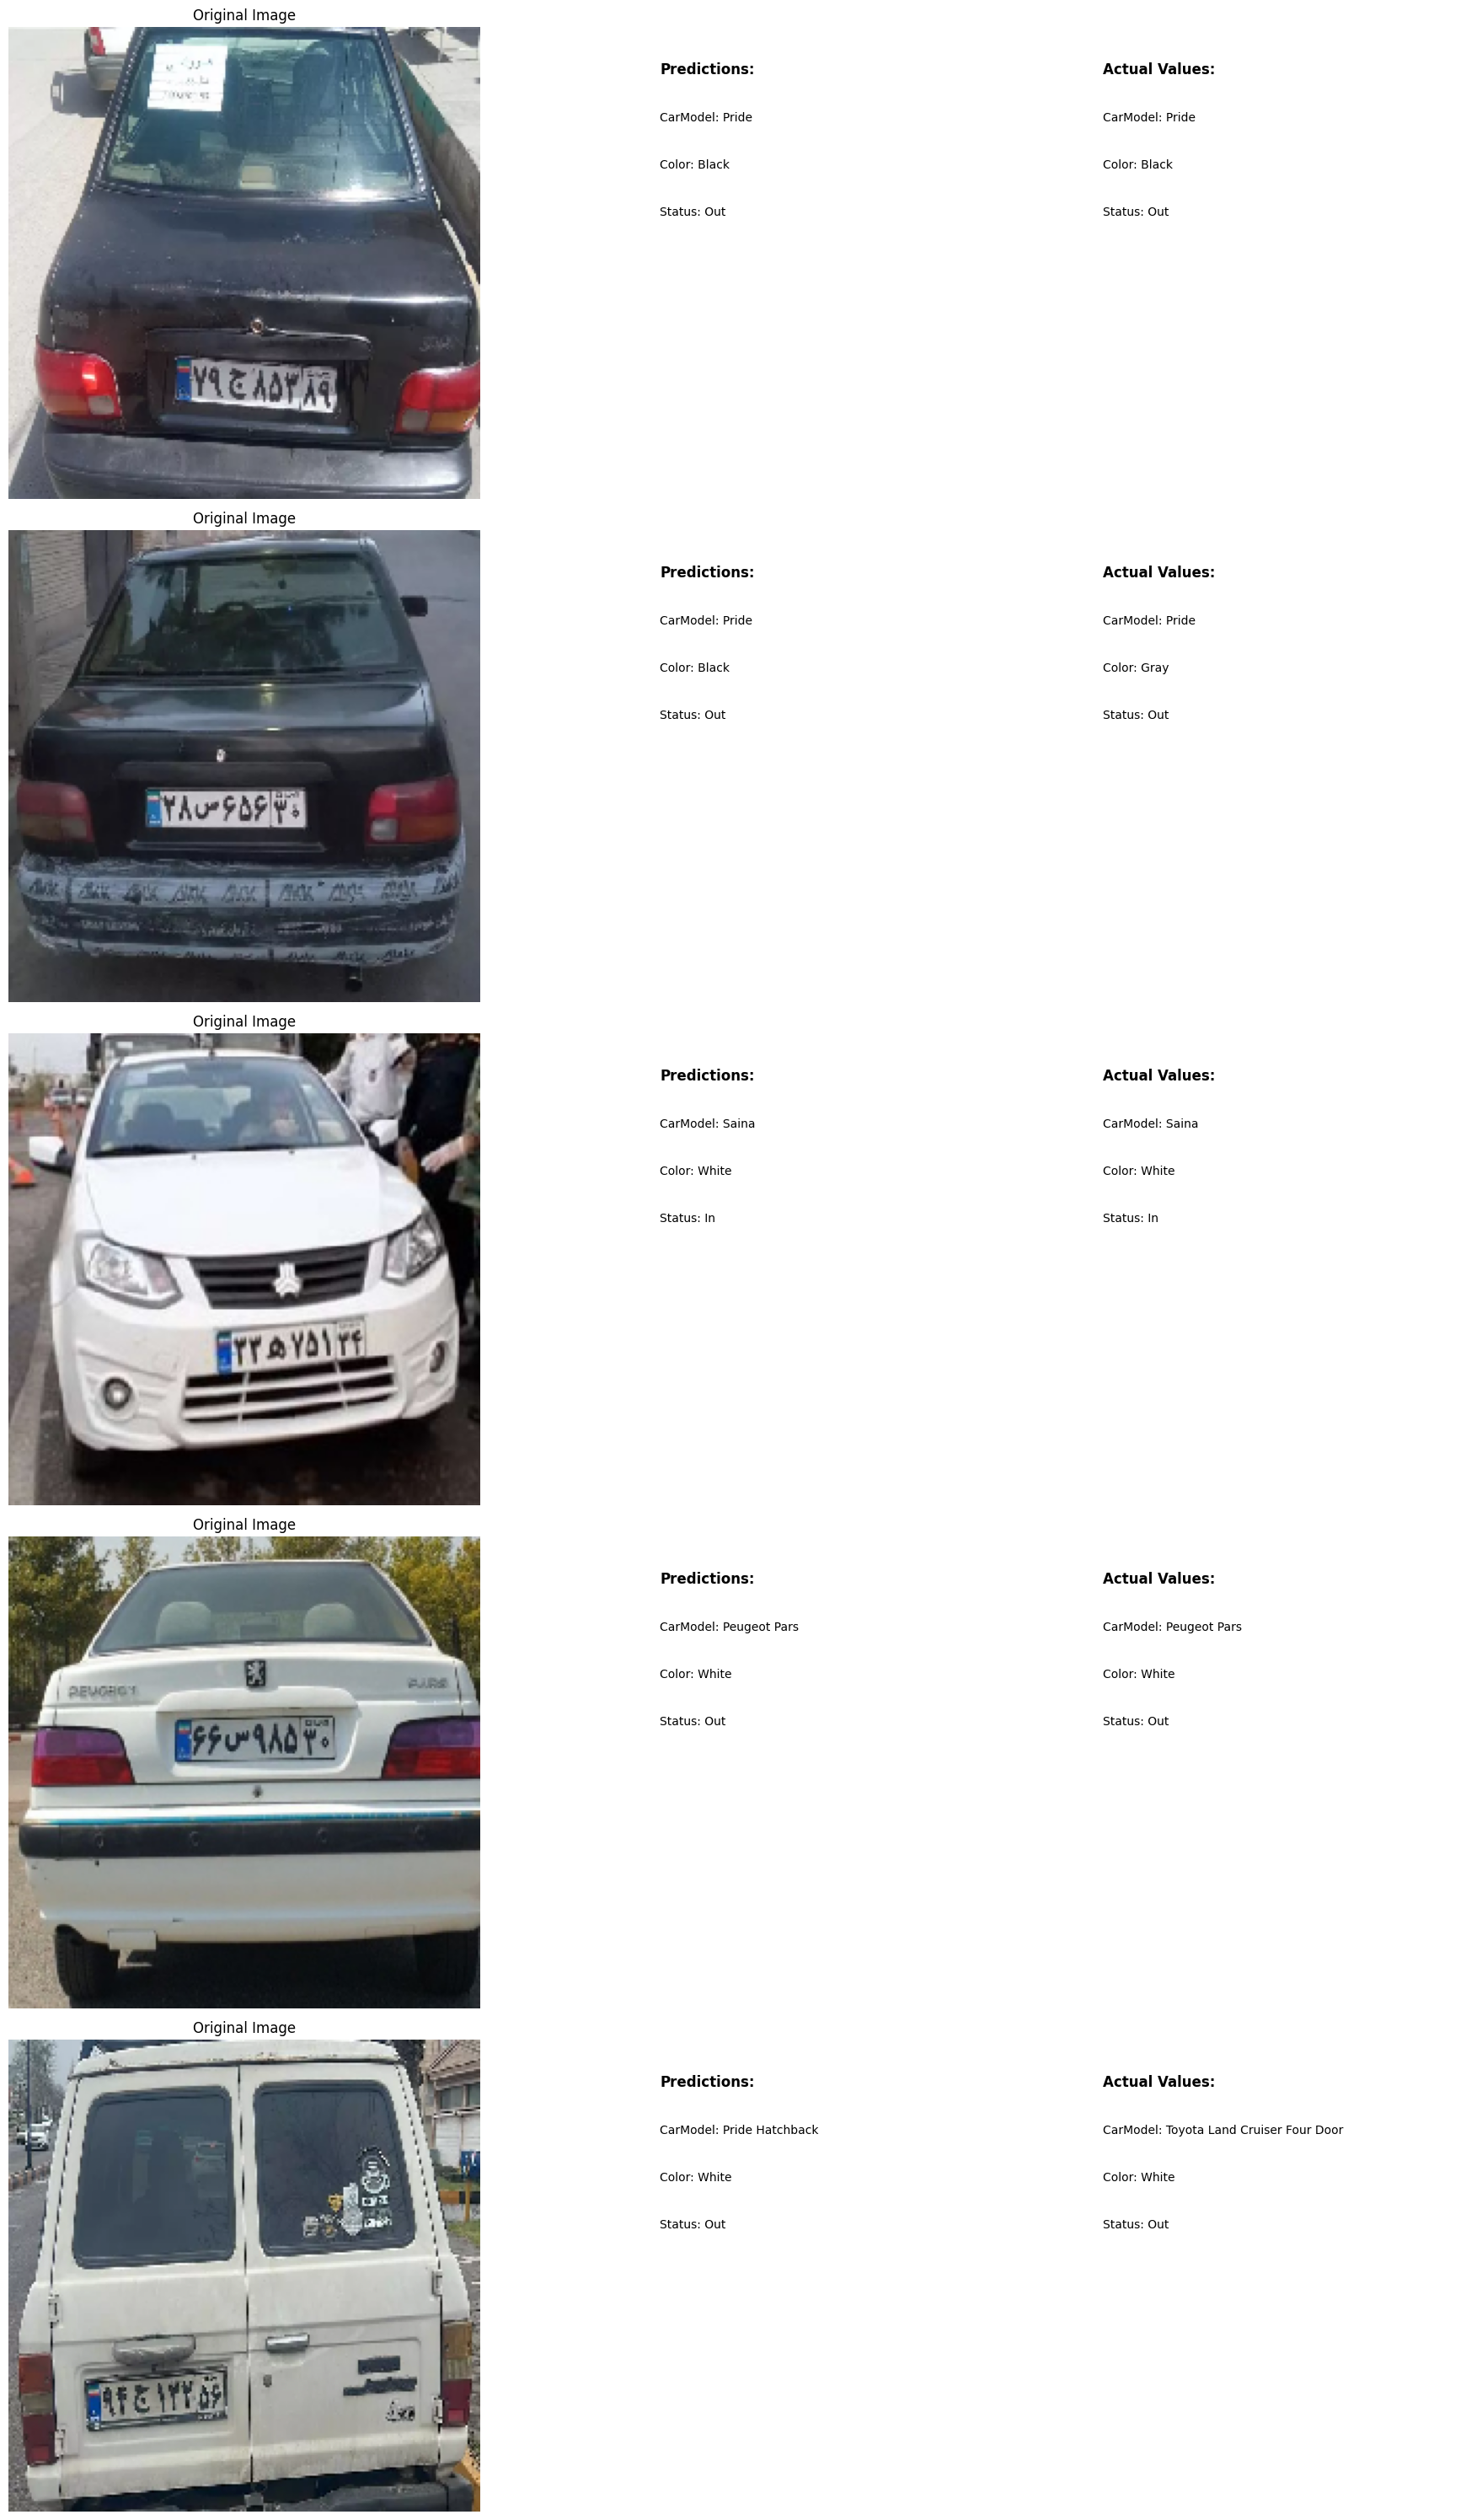

In [18]:
import matplotlib.pyplot as plt

def predict_and_display_random_images(metadata, model, num_images=5):
    random_images = metadata.sample(n=num_images)

    plt.figure(figsize=(20, 6*num_images))

    for i, (_, row) in enumerate(random_images.iterrows()):
        img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        predictions = model.predict(img_array)

        results = {}
        for column, pred in zip(categorical_columns, predictions.values()):
            predicted_class = label_encoders[column].inverse_transform([np.argmax(pred[0])])[0]
            results[column] = predicted_class

        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original Image")

        plt.subplot(num_images, 2, 2*i+2)
        plt.axis('off')
        plt.text(0.1, 0.9, "Predictions:", fontsize=12, fontweight='bold')
        for j, (key, value) in enumerate(results.items()):
            plt.text(0.1, 0.8 - j*0.1, f"{key}: {value}", fontsize=10)

        plt.text(0.6, 0.9, "Actual Values:", fontsize=12, fontweight='bold')
        for j, column in enumerate(categorical_columns):
            plt.text(0.6, 0.8 - j*0.1, f"{column}: {row[column]}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Use the function to visualize predictions
predict_and_display_random_images(val_data, model)